In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp
import random

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import Store
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = True
C = 15
L = 3

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(Location(20, 40), prime=False))
    customers.append(DoorToDoorCustomer(Location(15, 70), prime=False))
    customers.append(DoorToDoorCustomer(Location(30, 70), prime=True))
    customers.append(DoorToDoorCustomer(Location(80, 60), prime=True))
    customers.append(LockerCustomer(Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(Location(90, 50), prime=False))
    customers.append(LockerCustomer(Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf")))
    for l in range(L):
        stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    for c in range(C):
        if random.random() < ratio_locker_customers:
            customers.append(LockerCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), Customer.get_nearest_store(stores)))
        else:
            if random.random() < ratio_prime_door_to_door_customer:
                customers.append(DoorToDoorCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), prime=True))
            else:
                customers.append(DoorToDoorCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), prime=False))


In [5]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
S_k = list(filter(lambda customer: type(customer) == DoorToDoorCustomer and customer.prime == False, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(VehicleType.LF, store, math.ceil(0.6 * store.capacity)))


In [6]:
# define some np.array to plot the map
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])
for sk in S_k:
    S_k_location = np.vstack([S_k_location, [sk.location.x, sk.location.y]])

S_k_location = np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

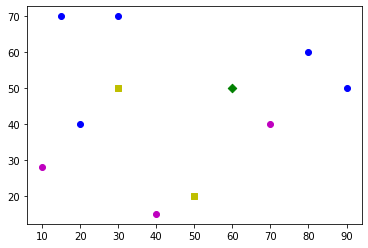

In [7]:
# plot the map
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [8]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)


             W         L1         L2        CD0        CD1        CD2  \
W     0.000000  30.000000  31.622777  41.231056  49.244289  36.055513   
L1   30.000000   0.000000  36.055513  14.142136  25.000000  20.000000   
L2   31.622777  36.055513   0.000000  36.055513  61.032778  53.851648   
CD0  41.231056  14.142136  36.055513   0.000000  30.413813  31.622777   
CD1  49.244289  25.000000  61.032778  30.413813   0.000000  15.000000   
CD2  36.055513  20.000000  53.851648  31.622777  15.000000   0.000000   
CD3  22.360680  50.990195  50.000000  63.245553  65.764732  50.990195   
CD4  30.000000  60.000000  50.000000  70.710678  77.620873  63.245553   
CL0  54.626001  29.732137  40.792156  15.620499  42.296572  46.518813   
CL1  14.142136  41.231056  28.284271  50.000000  62.649820  50.000000   
CL2  40.311289  36.400549  11.180340  32.015621  60.415230  55.901699   

           CD3        CD4        CL0        CL1        CL2  
W    22.360680  30.000000  54.626001  14.142136  40.311289  
L

In [9]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)


            W         L1         L2
W    0.000000  30.000000  31.622777
L1  30.000000   0.000000  36.055513
L2  31.622777  36.055513   0.000000
             W        CD0        CD1        CD2        CD3        CD4
W     0.000000  41.231056  49.244289  36.055513  22.360680  30.000000
CD0  41.231056   0.000000  30.413813  31.622777  63.245553  70.710678
CD1  49.244289  30.413813   0.000000  15.000000  65.764732  77.620873
CD2  36.055513  31.622777  15.000000   0.000000  50.990195  63.245553
CD3  22.360680  63.245553  65.764732  50.990195   0.000000  14.142136
CD4  30.000000  70.710678  77.620873  63.245553  14.142136   0.000000
            L1         L2        CD0        CD1        CD2        CD3  \
L1    0.000000  36.055513  14.142136  25.000000  20.000000  50.990195   
L2   36.055513   0.000000  36.055513  61.032778  53.851648  50.000000   
CD0  14.142136  36.055513   0.000000  30.413813  31.622777  63.245553   
CD1  25.000000  61.032778  30.413813   0.000000  15.000000  65.764732   
C

In [10]:
print(type(stores))
print(type(C_D))

<class 'list'>
<class 'list'>


In [11]:
# Delivery Cost

pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2
W    0.000000  22.500000  23.717082
L1  22.500000   0.000000  27.041635
L2  23.717082  27.041635   0.000000
             W        CD0        CD1        CD2        CD3        CD4
W     0.000000  41.231056  49.244289  36.055513  22.360680  30.000000
CD0  41.231056   0.000000  30.413813  31.622777  63.245553  70.710678
CD1  49.244289  30.413813   0.000000  15.000000  65.764732  77.620873
CD2  36.055513  31.622777  15.000000   0.000000  50.990195  63.245553
CD3  22.360680  63.245553  65.764732  50.990195   0.000000  14.142136
CD4  30.000000  70.710678  77.620873  63.245553  14.142136   0.000000
            L1         L2        CD0        CD1        CD2        CD3  \
L1    0.000000  30.647186  12.020815  21.250000  17.000000  43.341666   
L2   30.647186   0.000000  30.647186  51.877861  45.773901  42.500000   
CD0  12.020815  30.647186   0.000000  25.851741  26.879360  53.758720   
CD1  21.250000  51.877861  25.851741   0.000000  12.750000  55.900022   
C

In [12]:

LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+C_D,axis=1)
    ls = ls.filter(items=l+C_D,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]


            L1        CD0        CD1        CD2        CD3        CD4
L1    0.000000  12.020815  21.250000  17.000000  43.341666  51.000000
CD0  12.020815   0.000000  25.851741  26.879360  53.758720  60.104076
CD1  21.250000  25.851741   0.000000  12.750000  55.900022  65.977742
CD2  17.000000  26.879360  12.750000   0.000000  43.341666  53.758720
CD3  43.341666  53.758720  55.900022  43.341666   0.000000  12.020815
CD4  51.000000  60.104076  65.977742  53.758720  12.020815   0.000000
            L2        CD0        CD1        CD2        CD3        CD4
L2    0.000000  30.647186  51.877861  45.773901  42.500000  42.500000
CD0  30.647186   0.000000  25.851741  26.879360  53.758720  60.104076
CD1  51.877861  25.851741   0.000000  12.750000  55.900022  65.977742
CD2  45.773901  26.879360  12.750000   0.000000  43.341666  53.758720
CD3  42.500000  53.758720  55.900022  43.341666   0.000000  12.020815
CD4  42.500000  60.104076  65.977742  53.758720  12.020815   0.000000


In [13]:
#compensation

compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
compensation_matrix_cost_multidim = compensation_matrix_cost.to_numpy()
print(compensation_matrix_cost_multidim)


             W         L1         L2        Sk0        Sk1        Sk2
W     0.000000  30.000000  31.622777  41.231056  49.244289  30.000000
L1   30.000000   0.000000  36.055513  14.142136  25.000000  60.000000
L2   31.622777  36.055513   0.000000  36.055513  61.032778  50.000000
Sk0  41.231056  14.142136  36.055513   0.000000  30.413813  70.710678
Sk1  49.244289  25.000000  61.032778  30.413813   0.000000  77.620873
Sk2  30.000000  60.000000  50.000000  70.710678  77.620873   0.000000
          CL0        CL1        CL2
W   54.626001  14.142136  40.311289
L1  29.732137  41.231056  36.400549
L2  40.792156  28.284271  11.180340
CL0    L1
CL1     W
CL2    L2
dtype: object
[L1, W, L2]
          Sk0        Sk1   Sk2
L1  14.142136  25.000000  60.0
W   41.231056  49.244289  30.0
L2  36.055513  61.032778  50.0
          Sk0        Sk1   Sk2
L1   7.071068  12.500000  30.0
W   20.615528  24.622145  15.0
L2  18.027756  30.516389  25.0
[[ 7.07106781 12.5        30.        ]
 [20.61552813 24.622144

In [14]:
# Xpress formulation
single_period_problem = xp.problem()

In [15]:
# var definition with the right notation
'''
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)
x_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_PF)]for i in range(I_PF)], dtype=xp.npvar)
y_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_PF)]for i in range(I_PF)], dtype=xp.npvar)

I_L = 1 + L
J_L = 1 + L
x_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_L)]for i in range(I_L)], dtype=xp.npvar)
y_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_L)]for i in range(I_L)], dtype=xp.npvar)

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)
x_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_LF)]for i in range(I_LF)] for l in range(L)], dtype=xp.npvar)
y_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_LF)]for i in range(I_LF)] for l in range(L)], dtype=xp.npvar)

z_c = np.array([xp.var(name="z_c"+str(c), vartype=xp.binary) for c in range(len(C_D))], dtype=xp.npvar)
z_c_l = np.array([[xp.var(name="z_c"+str(c)+"_l"+str(l), vartype=xp.binary) for l in range(L)]for c in range(len(C_D))], dtype=xp.npvar)
z_l_L = np.array([[xp.var(name="z_l_L_"+str(l), vartype=xp.binary) for l in range(L)]], dtype=xp.npvar)

w_c_k = np.array([[xp.var(name="w_c"+str(c)+"_k"+str(k), vartype=xp.binary) for k in range(len(C_L))]for c in range(len(S_k))], dtype=xp.npvar)

# add var to the problem
single_period_problem.addVariable(x_i_j)
single_period_problem.addVariable(x_i_j_L)
single_period_problem.addVariable(x_l_i_j)

single_period_problem.addVariable(y_i_j)
single_period_problem.addVariable(y_i_j_L)
single_period_problem.addVariable(y_l_i_j)

single_period_problem.addVariable(z_c)
single_period_problem.addVariable(z_c_l)
single_period_problem.addVariable(z_l_L)

single_period_problem.addVariable(w_c_k)
'''

'\nI_PF = 1 + len(C_D)\nJ_PF = 1 + len(C_D)\nx_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_PF)]for i in range(I_PF)], dtype=xp.npvar)\ny_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_PF)]for i in range(I_PF)], dtype=xp.npvar)\n\nI_L = 1 + L\nJ_L = 1 + L\nx_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_L)]for i in range(I_L)], dtype=xp.npvar)\ny_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_L)]for i in range(I_L)], dtype=xp.npvar)\n\nI_LF = 1 + len(C_D)\nJ_LF = 1 + len(C_D)\nx_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for j in range(J_LF)]for i in range(I_LF)] for l in range(L)], dtype=xp.npvar)\ny_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for j in range(J_LF)]for i in range(I_LF)] for l in range(L)

In [16]:
# Xpress formulation
single_period_problem = xp.problem()

In [17]:
# var definition
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)
x_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)
y_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)

I_L = 1 + L
J_L = 1 + L
x_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)
y_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)
x_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)
y_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)

z_c = np.array([xp.var(name="z_c"+str(c), vartype=xp.binary) for c in range(len(C_D))], dtype=xp.npvar)
z_c_l = np.array([[xp.var(name="z_c"+str(c)+"_l"+str(l), vartype=xp.binary) for c in range(len(C_D))]for l in range(L)], dtype=xp.npvar)
z_l_L = np.array([[xp.var(name="z_l_L_"+str(l), vartype=xp.binary) for l in range(L)]], dtype=xp.npvar)

w_c_k = np.array([[xp.var(name="w_c"+str(c)+"_k"+str(k), vartype=xp.binary) for c in range(len(S_k))]for k in range(len(C_L))], dtype=xp.npvar)

# add var to the problem
single_period_problem.addVariable(x_i_j)
single_period_problem.addVariable(x_i_j_L)
single_period_problem.addVariable(x_l_i_j)

single_period_problem.addVariable(y_i_j)
single_period_problem.addVariable(y_i_j_L)
single_period_problem.addVariable(y_l_i_j)

single_period_problem.addVariable(z_c)
single_period_problem.addVariable(z_c_l)
single_period_problem.addVariable(z_l_L)

single_period_problem.addVariable(w_c_k)

In [18]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstraint( z_c[c] + xp.Sum(w_c_k[s][k] for s in range(len(S_k)) for k in range(len(C_L))) + xp.Sum(z_c_l[l][c] for l in range(L)) == 1)

# constraint eq. 3
for c_l in range(len(C_L)):
    single_period_problem.addConstraint( xp.Sum(w_c_k[c_l][s_k] for s_k in range(len(S_k))) <= 1)


# constraint eq. 4
for l in lockers:
    single_period_problem.addConstraint(
        xp.Sum(C_L[cl].package_demand + xp.Sum(S_k[sk].package_demand*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)) if C_L[cl].store == l)
        + xp.Sum(C_D[cd].package_demand*z_c_l[l.index-1][cd] for cd in range(len(C_D)))
        <= l.capacity * z_l_L[0][l.index-1]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )

# constraint eq. 6
single_period_problem.addConstraint(
    xp.Sum( x_i_j[0][j+1] for j in range(len(C_D)))
    - xp.Sum( x_i_j[j+1][0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j[j][i+1] for j in range(1+len(C_D)))
        - xp.Sum( y_i_j[i+1][j] for j in range(1+len(C_D)))
        == C_D[i].package_demand*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstraint(
    xp.Sum( y_i_j[j+1][0] for j in range(len(C_D)))
    - xp.Sum( y_i_j[0][j+1] for j in range(len(C_D)))
    == - xp.Sum( C_D[i].package_demand*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstraint(
            y_i_j[i][j]
            <= vehicles[1].capacity * x_i_j[i][j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        y_i_j[i+1][0]
        == 0
    )



# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[i+1][j] for j in range(1 + L))
        == z_l_L[0][i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[j][i+1] for j in range(1 + L))
        == z_l_L[0][i]
    )


# constraint eq. 12
single_period_problem.addConstraint(
    xp.Sum( x_i_j_L[0][j+1] for j in range(L))
    - xp.Sum( x_i_j_L[j+1][0] for j in range(L))
    == 0
)

# constraint eq. 13
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j_L[j][i+1] for j in range(1+L))
        - xp.Sum( y_i_j_L[i+1][j] for j in range(1+L))
        ==
        xp.Sum(C_L[cl].package_demand + xp.Sum(S_k[sk].package_demand*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + xp.Sum(C_D[c].package_demand*z_c_l[i][c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstraint(
    xp.Sum( y_i_j_L[j+1][0] for j in range(L))
    - xp.Sum( y_i_j_L[0][j+1] for j in range(L))
    == - xp.Sum(
        xp.Sum(C_L[cl].package_demand + xp.Sum(S_k[sk].package_demand*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + xp.Sum(C_D[c].package_demand*z_c_l[i][c] for c in range(len(C_D)))
        for i in range(L)
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstraint(
            y_i_j_L[i][j]
            <= vehicles[0].capacity * x_i_j_L[i][j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstraint(
        y_i_j_L[i+1][0]
        == 0
    )


# Local fleet constraints

for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][i+1][j] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][j][i+1] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )

    # constraint eq. 18
    single_period_problem.addConstraint(
        xp.Sum( x_l_i_j[l][0][j+1] for j in range(len(C_D)))
        - xp.Sum( x_l_i_j[l][j+1][0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( y_l_i_j[l][j][i+1] for j in range(1+len(C_D)))
            - xp.Sum( y_l_i_j[l][i+1][j] for j in range(1+len(C_D)))
            == C_D[i].package_demand*z_c_l[l][i]
        )

    # constraint eq. 20
    single_period_problem.addConstraint(
        xp.Sum( y_l_i_j[l][j+1][0] for j in range(len(C_D)))
        - xp.Sum( y_l_i_j[l][0][j+1] for j in range(len(C_D)))
        == - xp.Sum( C_D[i].package_demand*z_c_l[l][i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstraint(
                y_l_i_j[l][i][j]
                <= lockers[l].capacity * x_l_i_j[l][i][j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            y_l_i_j[l][i+1][0]
            == 0
        )


In [19]:
print(PF_delivery_cost)

             W        CD0        CD1        CD2        CD3        CD4
W     0.000000  41.231056  49.244289  36.055513  22.360680  30.000000
CD0  41.231056   0.000000  30.413813  31.622777  63.245553  70.710678
CD1  49.244289  30.413813   0.000000  15.000000  65.764732  77.620873
CD2  36.055513  31.622777  15.000000   0.000000  50.990195  63.245553
CD3  22.360680  63.245553  65.764732  50.990195   0.000000  14.142136
CD4  30.000000  70.710678  77.620873  63.245553  14.142136   0.000000


In [20]:
single_period_problem.setObjective(
    xp.Sum( xp.Sum(supply_cost.values[i][j]*x_i_j_L[i][j]   for j in range(1+L) )  for i in range(1+L))+
    xp.Sum( xp.Sum(compensation_matrix_cost_multidim[k][c] *w_c_k[c][k]  for c in range(len(S_k)))for k in range(len(C_L)))+
    xp.Sum( xp.Sum(PF_delivery_cost.values[i][j]*x_i_j[i][j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    xp.Sum( xp.Sum(xp.Sum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l][i][j] for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
    ,sense=xp.minimize
)   #sense=minimise is the default value

In [21]:
single_period_problem.solve()

FICO Xpress v8.13.5, Community, solve started 16:53:19, Jun 9, 2022
Heap usage: 438KB (peak 438KB, 359KB system)
Minimizing MILP noname using up to 4 threads, with these control settings:
OUTPUTLOG = 1
Original problem has:
       203 rows          260 cols          867 elements       260 globals
Presolved problem has:
       103 rows          154 cols          612 elements       154 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 525KB (peak 647KB, 359KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  7.00e+00] / [ 1.25e-01,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  6.00e+00] / [ 1.00e+00,  7.00e+00]
  Objective      [min,max] : [ 7.07e+00,  7.76e+01] / [ 3.46e-01,  1.62e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 5.8GB
 *** Solution found:   450.217240   Time:   0    Heuristic: e ***
 *** Solution found:   104.9